In [1]:
import numpy as np
import pymc3 as pm
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce

from plotutils import addtxt
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

\begin{align}
p(H \lvert D I ) &\propto p(D \lvert H, I) \cdot p(H\lvert I)\\
D&\equiv \text{Data, i.e., sequence of heads/tails}\\
H&\equiv \text{Bias weighting of the coin}\\
I&\equiv \text{Prior information}
\end{align}

\begin{align}
p(H\lvert I) &= \begin{cases}
1 & 0 \le H \le 1\\
0 & \text{otherwise}
\end{cases}\\
p(D \lvert H, I) &\propto H^{R}\left(1-H\right)^{N-R}
\end{align}

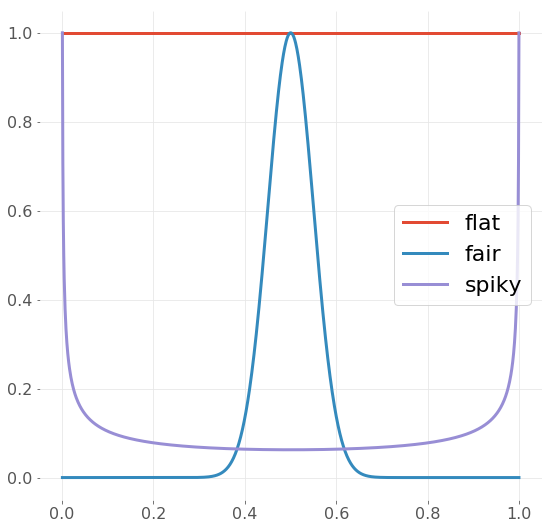

In [2]:
def normalize(f, dx=1.0): # normalize pdf
    return f / (np.sum(f)*dx) 
def normal(x,mu,sigma):   # normal distributed data
    return 1/(np.sqrt(2*np.pi) * sigma) * np.exp(-(x-mu)**2/(2*sigma**2))
def beta(x,alpha, beta):  # beta distributed data
    return x**alpha*(1-x)**beta

h_real = 0.25 # bias of our coin
hs     = np.linspace(0,1,num=2**10,endpoint=False)[1:] # grid of h values (ignore first and last points)
dh     = hs[1]-hs[0] # grid spacing

flat_prior = normalize(np.ones_like(hs), dh)
fair_prior = normalize(normal(hs, 0.5, 0.05), dh)
spiky_prior= normalize(beta(hs, -0.5, -0.5), dh)

fig, ax = plt.subplots(figsize=(9,9))
for prior,lbl in zip([flat_prior, fair_prior, spiky_prior], ['flat', 'fair', 'spiky']):
    ax.plot(hs, prior/np.max(prior), label=lbl)
ax.legend(fontsize=22)
plt.show()

\begin{align}
p(H \lvert D I ) &\propto p(D \lvert H, I) \cdot p(H\lvert I)\\
p(D \lvert H, I) &\propto H^{R}\left(1-H\right)^{N-R}\\
L \equiv \log{p(D\lvert H, I)}&= R\log{H} + (N-R)\log{(1-H)} + \log{p(H\lvert I)} + C
\end{align}

In [3]:
np.random.seed(1234567)
posteriors = []   # will contain the log(p(D|H,I))
last_draw  = []   # result of last coin toss
ntosses    = [0,1,2,3,4,8,16,32,64,128,256,512,1024,2048,4096] 
data       = np.random.choice([1, 0], size=ntosses[-1], p=[h_real, 1-h_real]) # tail = 0, heads = 1
for n in ntosses:
    sample      = data[:n] # analyze first n tosses only
    r           = np.sum(sample == 1)
    print(f'{r:5d} heads obtained after {n:5d} coin tosses')

    likelihood  = r*np.log(hs) + (n - r)*np.log(1-hs)        # p(D|H,I) ~ H^R * (1 - H)^(N - R)
    posteriors.append(likelihood + np.log(flat_prior))       # p(H|D,I) ~ p(D|H,I) p(H|I)
    if(n > 0):
        last_draw.append(sample[-1]) 
last_draw.insert(0, 0)

    0 heads obtained after     0 coin tosses
    1 heads obtained after     1 coin tosses
    2 heads obtained after     2 coin tosses
    3 heads obtained after     3 coin tosses
    3 heads obtained after     4 coin tosses
    7 heads obtained after     8 coin tosses
    9 heads obtained after    16 coin tosses
   14 heads obtained after    32 coin tosses
   25 heads obtained after    64 coin tosses
   42 heads obtained after   128 coin tosses
   71 heads obtained after   256 coin tosses
  126 heads obtained after   512 coin tosses
  266 heads obtained after  1024 coin tosses
  530 heads obtained after  2048 coin tosses
 1058 heads obtained after  4096 coin tosses


In [4]:
def get_posteriorpdf(logp): # compute normalized pdf
    normalization = reduce(np.logaddexp, logp) # log of normalization factor, logaddexp(loga,logb) = log(exp(log(a)) + exp(log(b))) = log(a + b)
    return np.exp(logp - np.sum(normalization))

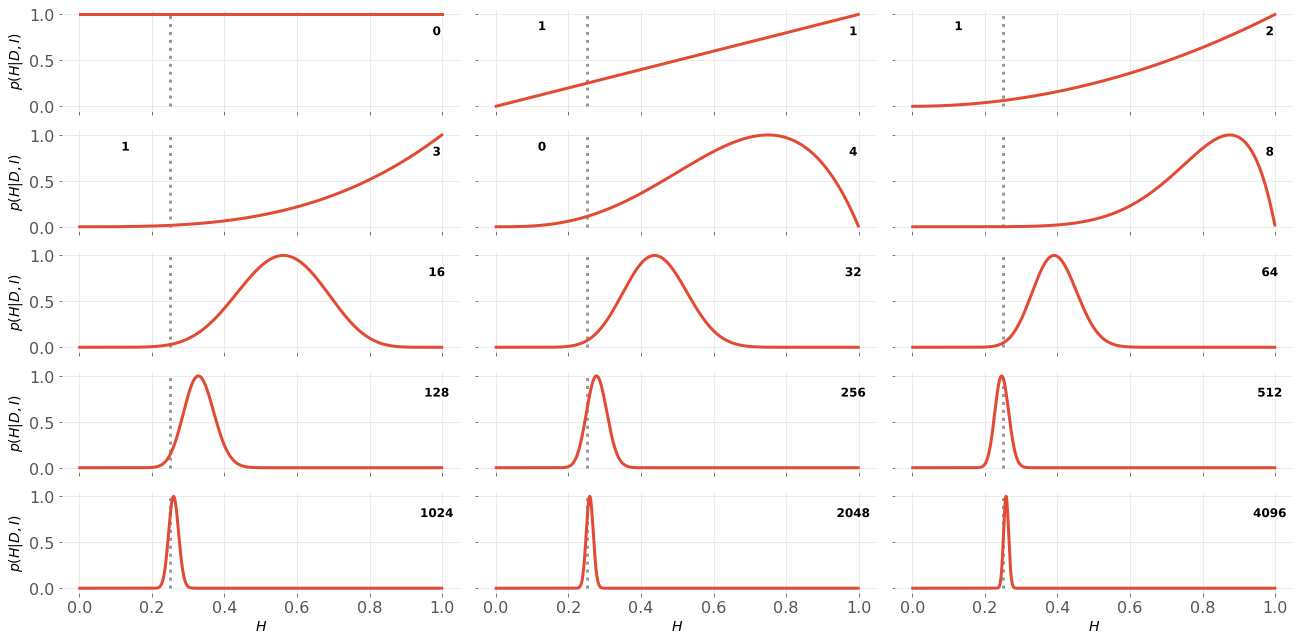

In [5]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18,9), sharex=True, sharey=True)
for ax,post,n,last in zip(axes.flatten(), posteriors, ntosses, last_draw):
    pdf = get_posteriorpdf(post)
    ax.plot(hs, pdf/np.max(pdf))
    addtxt(ax, 0.9, 0.75, f'{n:4d}', fs=12, lw=5)
    if n > 0 and n <= 4:
        addtxt(ax, 0.15, 0.8, f'{last}', fs=12, lw=5)
    ax.vlines(h_real, 0, 1, color='gray', linestyles=':', alpha=0.8)
for ax in axes[-1]:
    ax.set_xlabel(r'$H$', fontsize=14)
for ax in axes[:,0]:
    ax.set_ylabel(r'$p(H| D, I)$', fontsize=14)
fig.tight_layout()

In [6]:
# repeat previous experiment, but now use three different priors, resulting in three different posteriors
np.random.seed(1234567)
posteriors = []
posteriors_fair = []
posteriors_spiky=[]
ntosses    = [0,1,2,3,4,8,16,32,64,128,256,512,1024,2048,4096]
data       = np.random.choice([1, 0], size=ntosses[-1], p=[h_real, 1-h_real]) # tail = -1, heads = 1
for n in ntosses:
    sample      = data[:n]
    r           = np.sum(sample == 1)

    likelihood  = r*np.log(hs) + (n - r)*np.log(1-hs)   # p(D|H,I) ~ H^R * (1 - H)^(N - R)
    posteriors.append(likelihood + np.log(flat_prior))       # p(H|D,I) ~ p(D|H,I) p(H|I)
    posteriors_fair.append(likelihood + np.log(fair_prior))
    posteriors_spiky.append(likelihood + np.log(spiky_prior))

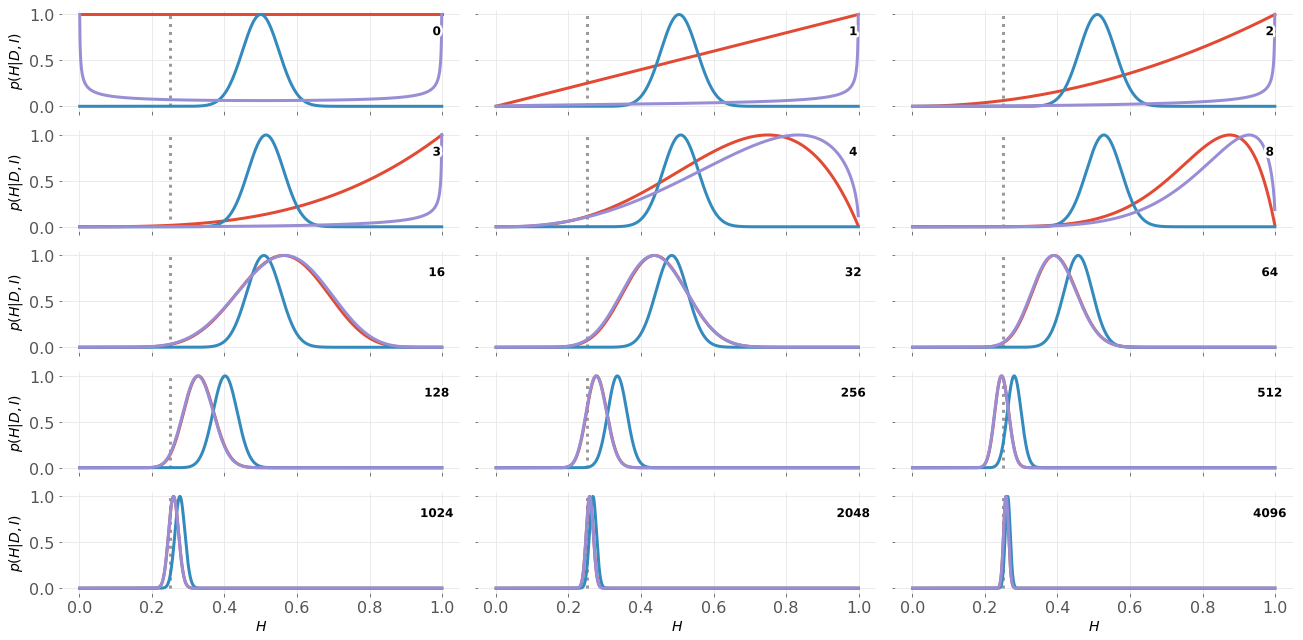

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18,9), sharex=True, sharey=True)
for ax,post,post_fair,post_spiky, n,last in zip(axes.flatten(), posteriors, posteriors_fair, posteriors_spiky, ntosses, last_draw):
    for p in [post, post_fair, post_spiky]:
        pdf = get_posteriorpdf(p)
        ax.plot(hs, pdf/np.max(pdf))
    
    addtxt(ax, 0.9, 0.75, f'{n:4d}', fs=12, lw=5)
    ax.vlines(h_real, 0, 1, color='gray', linestyles=':', alpha=0.8)

for ax in axes[-1]:
    ax.set_xlabel(r'$H$', fontsize=14)
for ax in axes[:,0]:
    ax.set_ylabel(r'$p(H| D, I)$', fontsize=14)
fig.tight_layout()

In [8]:
ndraws = 8
with pm.Model() as model:
    H = pm.Uniform('H', lower=0, upper=1)
    samples = pm.Bernoulli('samples', p = H, observed=data[:ndraws])

In [9]:
with model:
    trace = pm.sample(10000, init=None, cores=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [H]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:05<00:00, 3943.80draws/s]


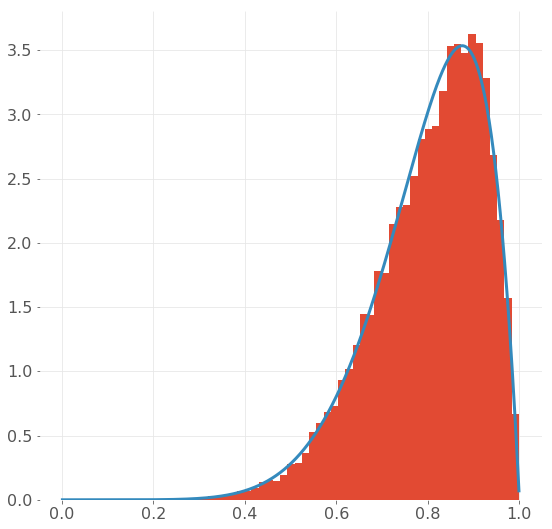

In [10]:
fig, ax = plt.subplots(figsize=(9,9))
ax.hist(trace['H'], density=True, bins=50)

pdf = get_posteriorpdf(posteriors[5])
ax.plot(hs, pdf/np.sum(pdf*dh))
plt.show()

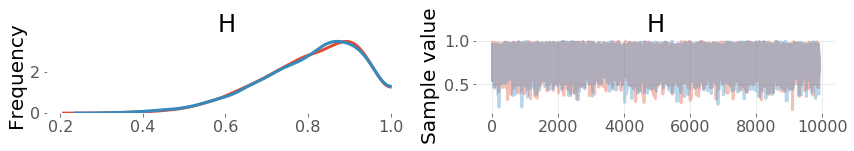

In [11]:
pm.traceplot(trace[100:]);

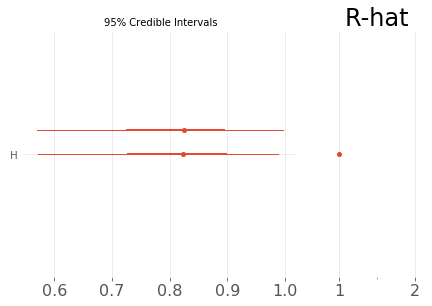

In [12]:
pm.forestplot(trace);

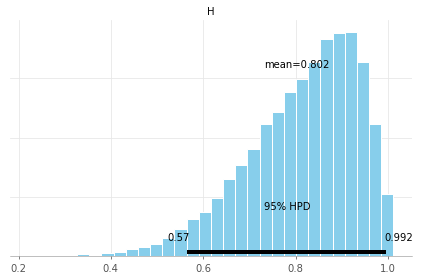

In [13]:
pm.plot_posterior(trace);